In [1]:
%load_ext autoreload
%autoreload 2
import os
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
from SRtools import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
import numpy as np
from SRtools import SR_hetro as srh
from SRtools import presets
import matplotlib.pyplot as plt
from SRtools import readResultsBaysian as rrb
from matplotlib import image as mpimg
from matplotlib import offsetbox
from SRtools import utils
from SRtools import plotting_utils as pu

In [2]:
save_fig = True
filetype = 'pdf'
life_span_param = 'best fit no ext hazard_MedianLifetime'

In [3]:
path ='results/summery_mode.csv'

In [4]:
# columns=[
#     'ecoli',
#     'mice_M', 'mice_F', 'yeast', 'celegance', 
#     'cats_BPH', 
#     'drosophila_853', 'drosophila_707', 'drosophila_441', 'drosophila_217',
#     'humans_M_combined', 'humans_F_combined', 
#     'Staffy_vetCompass', 'Labradors_vetCompass', 'Jack_Russell_vetCompass', 'German_Shepherd_vetCompass'
#     ]

columns = ['mice_F','mice_M','yeast','ecoli',#'cats_BPH',
        'drosophila_853','drosophila_707','drosophila_441','drosophila_217',
        'Sweden_M_1910_hetro','Sweden_F_1910_hetro','Denmark_M_1900_hetro','Denmark_M_1890_hetro',
        'Staffy_vetCompass','Labradors_vetCompass','Jack_Russell_vetCompass','German_Shepherd_vetCompass',
        'Denmark_F_1890_hetro', 'cats_vp_M', 'cats_vp_F',
        'celegans','Denmark_F_1900_hetro','Guiniea_pig_VC','combined_human_F','combined_human_M']

values_by_param, ci_by_param, selected_value_columns = utils.read_summary_csv(path,columns=columns)
# sil = utils.get_summery_csv_df(columns=columns)

In [5]:
columns_mass = ['yeast','mice_F','drosophila_441','Labradors_vetCompass','cats_vp_M','celegans','Guiniea_pig_VC','combined_human_F']

mass = {
    'yeast':1e-13,
    'mice_M':18e-3, 
    'drosophila_441':1e-6,
    'Labradors_vetCompass':40,
    'cats_vp_M':3.9,
    'celegans':1e-9,
    'Guiniea_pig_VC':0.728,
    'combined_human_F':62,

}

# for key in mass.keys():
    # mass[key] = 70*(mass[key]**0.75)

metabolic_rate= {
    'mice_M':0.2710 , #W/g
    'Guiniea_pig_VC':2.1300 ,
    'combined_human_F':82.78,

}

values_by_param_mass, ci_by_param_mass, selected_value_columns_mass = utils.read_summary_csv(path,columns=columns_mass)
print(values_by_param_mass['data_MedianLifetime'])
print(mass.values())


[3.25, 886.0, 50.0, 4487.88, 4577.1, 18.3, 1468.99, 29017.5]
dict_values([1e-13, 0.018, 1e-06, 40, 3.9, 1e-09, 0.728, 62])


In [6]:
print(values_by_param.keys())

dict_keys(['xc/eta', 'beta/eta', 'xc^2/epsilon', 'xc', 'eta', 'beta', 'epsilon', 'sqrt(xc/eta)', 's= eta^0.5*xc^1.5/epsilon', 'beta*xc/epsilon', 'eta*xc/epsilon', 'Fx=beta^2/eta*xc', 'Dx =beta*epsilon/eta*xc^2', 'Pk=beta*k/epsilon', 'Fk=beta^2/eta*k', 'Dk =beta*epsilon/eta*k^2', 'Fk^2/Dk=beta^3/eta*epsilon', 'epsilon/beta^2', 'k/beta', 'k^2/epsilon', 'best fit no ext hazard_MedianLifetime', 'best fit no ext hazard_MaxLifetime', 'best fit_MedianLifetime', 'best fit_MaxLifetime', 'data_MedianLifetime', 'data_MaxLifetime', 'ML_lnprob', 'ExtH', 'eta/xc', 'beta/xc', 'epsilon/xc^2', 'k/xc'])


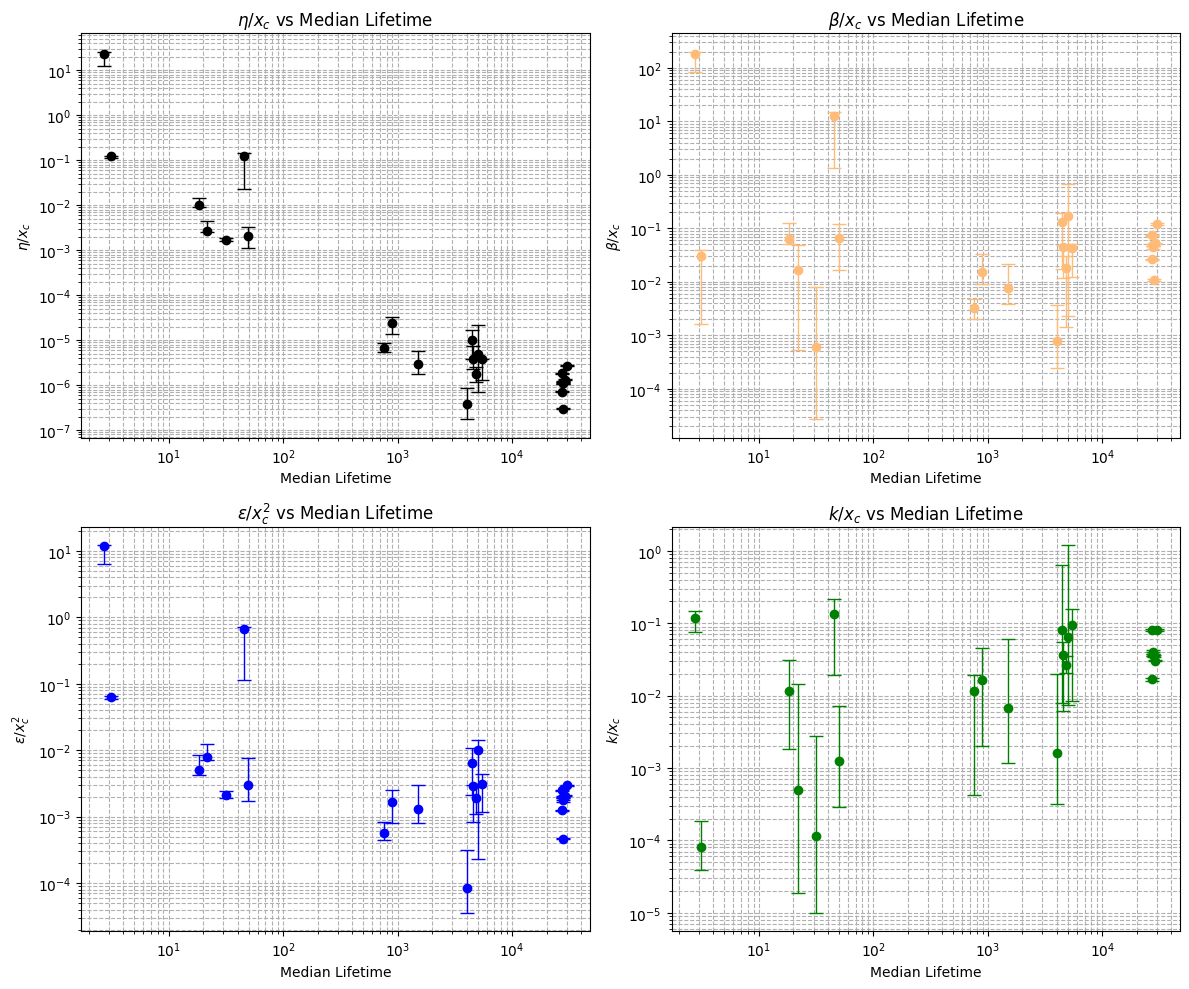

In [7]:
ML = values_by_param[life_span_param]
epsilon = values_by_param['epsilon/xc^2']
epsilon_ci = ci_by_param['epsilon/xc^2']
eta = values_by_param['eta/xc']
eta_ci = ci_by_param['eta/xc']
beta = values_by_param['beta/xc']
beta_ci = ci_by_param['beta/xc']
k = values_by_param['k/xc']
k_ci = ci_by_param['k/xc']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define colors for each parameter
param_colors = {
    "eta/xc": "black",
    "beta/xc": "#ffbb78",      # light orange (Matplotlib's default color palette)
    "epsilon/xc^2": "blue",
    "k/xc": "green"
}

# Helper function to plot on log-log with error bars and specified color
def plot_param_vs_ML(ax, param, param_ci, label, ylabel, color):
    ml = np.array(ML)
    p = np.array(param)
    # Compute yerr from CI info, flexible to CI shape
    if isinstance(param_ci, list) or isinstance(param_ci, tuple):
        param_ci = np.array(param_ci)
    if param_ci.shape[0] == 2 and param_ci.shape[1] == len(p):
        yerr = np.abs(param_ci - p)
    elif param_ci.shape == (len(p), 2):
        yerr = np.abs(param_ci.T - p)
    else:
        yerr = None
    if yerr is not None:
        ax.errorbar(
            ml, p, 
            yerr=yerr, 
            fmt='o', 
            capsize=5,
            elinewidth=1,
            markeredgewidth=1,
            linewidth=0,
            label=label,
            color=color,
            ecolor=color
        )
    else:
        ax.plot(ml, p, 'o', label=label, color=color)
    ax.set_xlabel("Median Lifetime")
    ax.set_ylabel(ylabel)
    ax.grid(True, which="both", ls="--")
    ax.set_xscale("log")
    ax.set_yscale("log")

# eta vs ML (black)
plot_param_vs_ML(axs[0,0], eta, eta_ci, "eta/xc", r'$\eta/x_c$', param_colors["eta/xc"])
axs[0,0].set_title(r'$\eta/x_c  $ vs Median Lifetime')

# beta vs ML (light orange)
plot_param_vs_ML(axs[0,1], beta, beta_ci, "beta/xc", r'$\beta/x_c$', param_colors["beta/xc"])
axs[0,1].set_title(r'$\beta/x_c$ vs Median Lifetime')

# epsilon vs ML (blue)
plot_param_vs_ML(axs[1,0], epsilon, epsilon_ci, "epsilon/xc^2", r'$\epsilon/x_c^2$', param_colors["epsilon/xc^2"])
axs[1,0].set_title(r'$\epsilon/x_c^2$ vs Median Lifetime')

# x_c vs ML (green)
plot_param_vs_ML(axs[1,1], k, k_ci, "k/xc", r'$k/x_c$', param_colors["k/xc"])
axs[1,1].set_title(r'$k/x_c$ vs Median Lifetime')

plt.tight_layout()
plt.show()


(8,) (8, 2)


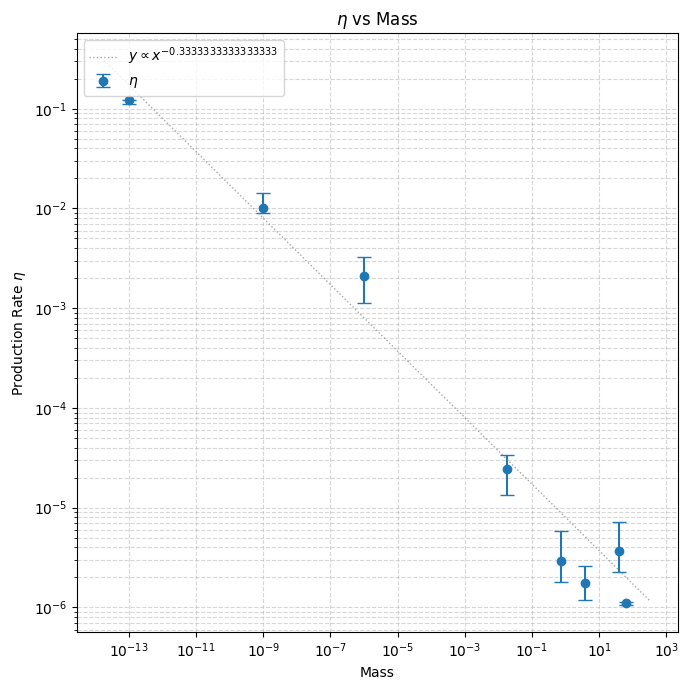

In [8]:
# Plot eta vs mass with CI

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

mass_metabolic = []
metabolic_values = []
for key in metabolic_rate.keys():
    mass_metabolic.append(mass[key])
    metabolic_values.append(metabolic_rate[key])

# Assume you have: 'mass', 'eta', 'eta_ci', 'eta_over_xc', 'eta_over_xc_ci', 'metabolic_rate', and 'mass_label'
# If not, please adapt variable names accordingly.
eta = values_by_param_mass['eta/xc']
eta_ci = ci_by_param_mass['eta/xc']
print(np.shape(eta),np.shape(eta_ci))

# Helper function to add y=x^alpha reference lines, now supports negative powers
def add_power_lines(ax, powers=None, color='gray', alpha_val=0.7,shift=1000):
    # Get xlim & ylim in log space
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    x_grid = np.logspace(np.log10(xlims[0]), np.log10(xlims[1]), 100)
    if powers is None:
        powers = [0.25, 0.5, 0.75]
    ls_styles = [':', '--', '-.']
    for p, ls in zip(powers, ls_styles):
        y_grid = x_grid ** p*shift
        sign_string = "-" if p < 0 else ""
        p_display = f"{sign_string}{abs(p)}"
        ax.plot(x_grid, y_grid, ls, color=color, alpha=alpha_val, linewidth=1, label=fr'$y \propto x^{{{p}}}$')
    # Only show one label in the legend
    handles, labels = ax.get_legend_handles_labels()
    # keep only one y∝x^p label per power, avoiding duplicates
    new_handles, new_labels = [], []
    added_powers = set()
    for h, l in zip(handles, labels):
        if l.startswith('y \\propto x'):
            pstr = l
            if pstr not in added_powers:
                added_powers.add(pstr)
                new_handles.append(h)
                new_labels.append(l)
        else:
            new_handles.append(h)
            new_labels.append(l)
    ax.legend(new_handles, new_labels, loc="upper left")

# eta vs mass with CI
ax.errorbar(
    mass.values(), eta, 
    yerr=[np.abs(np.array(eta_ci)[:,0] - np.array(eta)), np.abs(np.array(eta_ci)[:,1] - np.array(eta))], 
    fmt='o', capsize=5, color='C0', label=r'$\eta$'
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mass")
ax.set_ylabel(r'Production Rate $\eta$')
ax.grid(True, which="both", ls="--", alpha=0.5)

plt.draw()  # Ensures proper axis limits before plotting power lines
add_power_lines(ax, powers=[-1/3], shift=0.000008)

handles, labels = ax.get_legend_handles_labels()
ax.legend(loc="upper left")
ax.set_title(r'$\eta$ vs Mass')

plt.tight_layout()
plt.show()


In [9]:


file_image_dict={
    'mice_F': 'silhouetts/Mice.jpg',
    'celegans': 'silhouetts/Celegance.jpeg',
    'Labradors_vetCompass': 'silhouetts/Labrador.jpg',
    'drosophila_441': 'silhouetts/drosophila.jpeg',
    'cats_vp_M': 'silhouetts/cat silhouette.jpeg',
    'combined_human_F': 'silhouetts/man silhouette.jpeg',
    'yeast': 'silhouetts/yeast.jpg',
    'ecoli': 'silhouetts/ecoli.jpeg',
    'Guiniea_pig_VC': 'silhouetts/guinea_pig_silhouette.jpeg',
}



fact_zoom=0.8
x_offset_fact =1.2
zooms = {
    'mice_F': 0.015*fact_zoom,
    'celegans': 0.0125*fact_zoom,
    'Labradors_vetCompass': 0.02*fact_zoom,
    'drosophila_441': 0.01*fact_zoom,
    'cats_vp_M': 0.02*fact_zoom,
    'combined_human_F': 0.025*fact_zoom,
    'yeast': 0.01*fact_zoom,
    'ecoli': 0.01*fact_zoom,
    'Guiniea_pig_VC': 0.01*fact_zoom,
}


directions = {
    'mice_F': -1,
    'celegans': -1,
    'Labradors_vetCompass': -1,
    'drosophila_441': 1,
    'cats_vp_M': 1,
    'combined_human_F': 1,
    'yeast': 1,
    'ecoli': 1,
    'Guiniea_pig_VC': -1,
}



offsets_eta = {
    'mice_F': [1*x_offset_fact,-3],
    'celegans': [2*x_offset_fact,0],
    'Labradors_vetCompass': [2.5*x_offset_fact,0],
    'drosophila_441': [3*x_offset_fact,0],
    'cats_vp_M': [3*x_offset_fact,-3.5],
    'combined_human_F': [3*x_offset_fact,-1.5],
    'yeast': [3.2*x_offset_fact,0],
    'ecoli': [3.5*x_offset_fact,-1],
    'Guiniea_pig_VC': [2.8*x_offset_fact,-1.2],
}


plot_props_eta = rrb.getPlotPropsImages(file_image_dict=file_image_dict, zooms=zooms,offset=offsets_eta,directions=directions)






In [10]:
alpha_1 =0.2
color = 'black'
marker_size = 6
markeredgewidth = 1
marker = 'o'

plot_props_all = {
    'combined_human_M': {'color': color, 'marker': marker, 'label': 'Human Male', 'alpha': alpha_1, 'markersize': marker_size, 'markeredgewidth': markeredgewidth},
    'combined_human_F': {'color': color, 'marker': marker, 'label': 'Human Female', 'alpha': alpha_1, 'markersize': marker_size, 'markeredgewidth': markeredgewidth},
    'ecoli': {'color': color, 'marker': marker, 'label': 'E. coli', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Jack_Russell_vetCompass': {'color': color, 'marker': marker, 'label': 'Jack Russell', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Labradors_vetCompass': {'color': color, 'marker': marker, 'label': 'Labrador', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Staffy_vetCompass': {'color': color, 'marker': marker, 'label': 'Staffy', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'German_Shepherd_vetCompass': {'color': color, 'marker': marker, 'label': 'German Shepherd', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'cats_vp_M': {'color': color, 'marker': marker, 'label': 'Cats', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'cats_vp_F': {'color': color, 'marker': marker, 'label': 'Cats', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'mice_F': {'color': color, 'marker': marker, 'label': 'Mice Female', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'mice_M': {'color': color, 'marker': marker, 'label': 'Mice Male', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'celegans': {'color': color, 'marker': marker, 'label': 'C. elegans', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_853': {'color': color, 'marker': marker, 'label': 'Drosophila genotype 853', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_441': {'color': color, 'marker': marker, 'label': 'Drosophila genotype 441', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_707': {'color': color, 'marker': marker, 'label': 'Drosophila genotype 707', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'drosophila_217': {'color': color, 'marker': marker, 'label': 'Drosophila genotype 217', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'yeast': {'color': color, 'marker': marker, 'label': 'Yeast', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
    'Guiniea_pig_VC': {'color': color, 'marker': marker, 'label': 'Guinea Pig', 'alpha': alpha_1, 'markersize': marker_size, 'markerfacecolor': 'none', 'markeredgewidth': markeredgewidth},
}

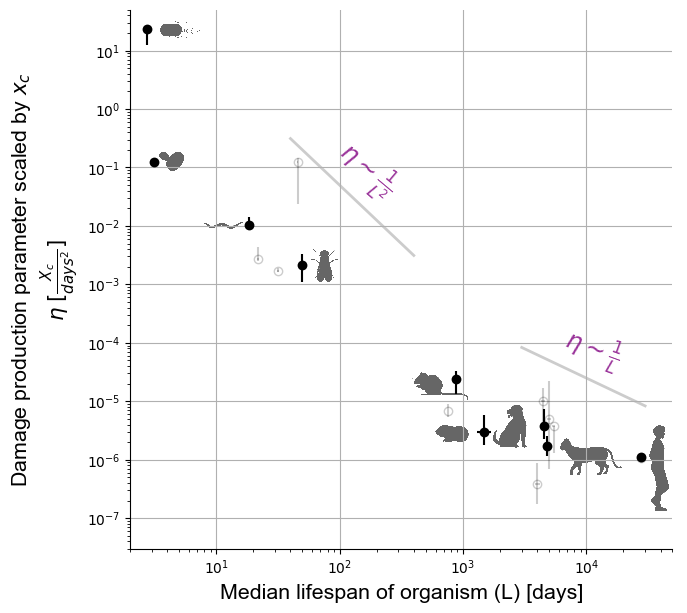

In [11]:
sf =0.7

fig_size = (10*sf,10*sf) 
fig, ax = plt.subplots(figsize=fig_size)
# fig.subplots_adjust(wspace=0.4) 

x2= np.array([40,400,])
x1 =np.array([3000,30000])
y2 =np.array([1/(xi**2) for xi in x2])*500
y1=np.array([1/(xi) for xi in x1])/4


# if i in [8,7,6]:
#     dparam = idict[20]
# elif i in [11,2,3]:
#     mparam = idict[20]
# elif i in[1]:
#     mparam = [idict[20],idict[20]]

title_font = {'fontname':'Arial', 'size':f'{22*sf}', 'color':'black', 'weight':'normal'}
axis_font = {'fontname':'Arial', 'size':f'{22*sf}','weight':'normal','alpha':1}
text_font = {'fontname':'Arial', 'size':f'{25*sf}','color':'purple','alpha':0.80,'weight':'bold','horizontalalignment':'left','verticalalignment':'bottom'}

npad =10



i =1
dparam = None
mparam = None

_, _,_,_,_,_, fig,plot_props0 =pu.plotParams2D(path,ax=ax,param2='eta/xc',multiply_param2=mparam,divide_by_param2=dparam,param1=life_span_param,divide_by_param1=None,yscale='log',xscale='log',
                                               full_output=True,legend = False,plot_props_images=plot_props_eta,best_fit=False)
_, _,_,_,_,_, fig,plot_props0 =pu.plotParams2D(path,ax=ax,param2='eta/xc',multiply_param2=mparam,divide_by_param2=dparam,param1=life_span_param,divide_by_param1=None,yscale='log',xscale='log',
                                               full_output=True,legend = False,best_fit=False, plot_props = plot_props_all)
# _, _,_,_,_,_, fig,plot_props0 =rr.plotParams2D(sil,ax=ax,param2=idict[i],multiply_param2=mparam,divide_by_param2=dparam,param1=idict[20],divide_by_param1=None,yscale='log',xscale='log',
#                                                full_output=True,legend = False,plot_props_images=plot_props_eta,image_color='purple',best_fit=False,drop_images=True)
ax.plot(x1, y1, color='black', linestyle='-', linewidth=2, alpha=0.2, zorder=1)
ax.plot(x2, y2, color='black', linestyle='-', linewidth=2, alpha=0.2, zorder=1)
ax.set_title('Damage production parameter $\\eta$ inversely correlates with lifespan', pad=ax.title.get_position()[1] + npad, **title_font)
# rr.plotParams2D(sil,ax=ax,param2=idict[i],multiply_param2=mparam,divide_by_param2=dparam,param1=idict[20],divide_by_param1=None,yscale='log',xscale='log',full_output=False,legend = False)
ax.set_ylabel(r'Damage production parameter scaled by $x_c$'+'\n'+r'$\eta$ $[\frac{X_c}{days^2}]$', **axis_font)
ax.set_xlabel('Median lifespan of organism (L) [days]',labelpad=5, **axis_font)
ax.set_xlim(2, 50000)
ax.set_ylim(0.00000003, 50)
ax.text(80, 0.2/10, r'$\eta\sim\frac{1}{L^2}$', rotation=-40, **text_font)
ax.text(6000, 0.25e-4, r'$\eta\sim\frac{1}{L}$', rotation=-20, **text_font)

#remove title
ax.title.set_visible(False)

if save_fig:
    fig.savefig(f'plots/MainFig_Eta_Silhouetts.{filetype}',bbox_inches='tight',format=filetype,transparent=True)


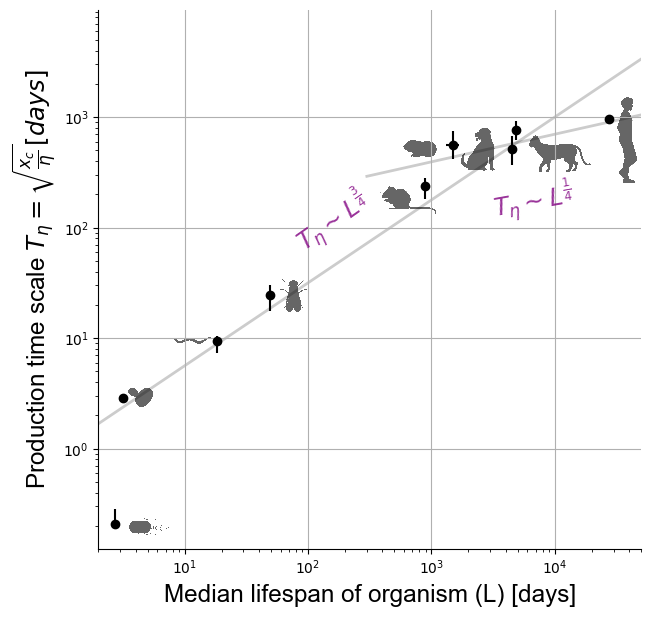

In [12]:
sf =0.7

fig_size = (10*sf,10*sf) 
fig, ax = plt.subplots(figsize=fig_size)
# fig.subplots_adjust(wspace=0.4) 

x2= np.array([1,10,100,1000,10000,100000])
x1 =np.array([300,1000,10000,100000])
y2 =np.array([(xi**(3/4)) for xi in x2])
y1=np.array([(xi**0.25) for xi in x1])*70


# if i in [8,7,6]:
#     dparam = idict[20]
# elif i in [11,2,3]:
#     mparam = idict[20]
# elif i in[1]:
#     mparam = [idict[20],idict[20]]

title_font = {'fontname':'Arial', 'size':f'{22*sf}', 'color':'black', 'weight':'normal'}
axis_font = {'fontname':'Arial', 'size':f'{25*sf}','weight':'normal','alpha':1}
text_font = {'fontname':'Arial', 'size':f'{25*sf}','color':'purple','alpha':0.80,'weight':'bold','horizontalalignment':'left','verticalalignment':'bottom'}

npad =10



i =1
dparam = None
mparam = None

_, _,_,_,_,_, fig,plot_props0 =pu.plotParams2D(path,ax=ax,param2='sqrt(xc/eta)',multiply_param2=mparam,divide_by_param2=dparam,param1=life_span_param,divide_by_param1=None,yscale='log',xscale='log',
                                               full_output=True,legend = False,plot_props_images=plot_props_eta,best_fit=False)
# _, _,_,_,_,_, fig,plot_props0 =rr.plotParams2D(sil,ax=ax,param2=idict[i],multiply_param2=mparam,divide_by_param2=dparam,param1=idict[20],divide_by_param1=None,yscale='log',xscale='log',
#                                                full_output=True,legend = False,plot_props_images=plot_props_eta,image_color='purple',best_fit=False,drop_images=True)
ax.plot(x1, y1, color='black', linestyle='-', linewidth=2, alpha=0.2, zorder=1)
ax.plot(x2, y2, color='black', linestyle='-', linewidth=2, alpha=0.2, zorder=1)
ax.set_title(r'Damage production time scale $\sqrt(x_c/\eta)$ inversely correlates with lifespan', pad=ax.title.get_position()[1] + npad, **title_font)
# rr.plotParams2D(sil,ax=ax,param2=idict[i],multiply_param2=mparam,divide_by_param2=dparam,param1=idict[20],divide_by_param1=None,yscale='log',xscale='log',full_output=False,legend = False)
ax.set_ylabel( r'Production time scale $T_\eta=\sqrt{\frac{x_c}{\eta}} [days]$', **axis_font)
ax.set_xlabel('Median lifespan of organism (L) [days]',labelpad=5, **axis_font)
ax.set_xlim(2, 50000)
# ax.set_ylim(0.1, 5000)
ax.text(70, 50, r'$T_\eta\sim L^\frac{3}{4}$', rotation=35, **text_font)
ax.text(3000, 100, r'$T_\eta\sim L^\frac{1}{4}$', rotation=10, **text_font)

#remove title
ax.title.set_visible(False)

if False:
    fig.savefig(f'plots/MainFig_Eta_Silhouetts.{filetype}',bbox_inches='tight',format=filetype,transparent=True)
